In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.0 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="qwF3hf1QV5TchFJVLQLg")
project = rf.workspace("new-project-1").project("dhineu_mv4-60bqt")
version = project.version(1)
dataset = version.download("yolov8")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 137.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to DHINEU_MV4-1 in yolov8:: 100%|██████████| 452/452 [00:00<00:00, 8462.68it/s]


In [ ]:
import cv2
import albumentations as A
import os
from tqdm import tqdm


# Original dataset paths
IMG_DIR = "/content/DHINEU_MV4-1/train/images"
LABEL_DIR = "/content/DHINEU_MV4-1/train/labels"

# Output augmented dataset paths
OUTPUT_IMG_DIR = "/content/DHINEU_MV4-1_aug/images/train"
OUTPUT_LABEL_DIR = "/content/DHINEU_MV4-1_aug/labels/train"

# Number of augmented images per original image
AUGMENT_PER_IMAGE = 10
os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)


transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.5),
    A.Affine(translate_percent={"x":0.1, "y":0.1},
             scale={"x":0.8, "y":1.2},
             rotate=(-20,20), p=0.7),
    A.RandomFog(p=0.2),
    A.RandomRain(p=0.2)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


def read_label(path):
    """Read YOLO label file and return bounding boxes and class labels"""
    if not os.path.exists(path):
        return [], []
    with open(path, "r") as f:
        lines = f.readlines()
    bboxes, class_labels = [], []
    for line in lines:
        cls, x, y, w, h = line.strip().split()
        bboxes.append([float(x), float(y), float(w), float(h)])
        class_labels.append(int(cls))
    return bboxes, class_labels

def write_label(path, bboxes, class_labels):
    """Write YOLO label file"""
    with open(path, "w") as f:
        for cls, box in zip(class_labels, bboxes):
            f.write(f"{cls} {box[0]} {box[1]} {box[2]} {box[3]}\n")


if not os.path.exists(IMG_DIR):
    raise FileNotFoundError(f"Image folder not found: {IMG_DIR}")

for img_file in tqdm(os.listdir(IMG_DIR)):
    if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    img_path = os.path.join(IMG_DIR, img_file)
    label_path = os.path.join(LABEL_DIR, img_file.rsplit('.',1)[0] + '.txt')

    bboxes, class_labels = read_label(label_path)
    if len(bboxes) == 0:
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    for i in range(AUGMENT_PER_IMAGE):
        augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)
        aug_img = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['class_labels']

        out_img_path = os.path.join(OUTPUT_IMG_DIR, img_file.rsplit('.',1)[0] + f'_aug{i}.jpg')
        out_label_path = os.path.join(OUTPUT_LABEL_DIR, img_file.rsplit('.',1)[0] + f'_aug{i}.txt')

        cv2.imwrite(out_img_path, aug_img)
        write_label(out_label_path, aug_bboxes, aug_labels)

print("✅ Dataset augmentation completed!")


100%|██████████| 195/195 [02:23<00:00,  1.36it/s]

✅ Dataset augmentation completed!


In [ ]:
import os
import cv2
import albumentations as A
from tqdm import tqdm
import shutil


# Original dataset paths
ORIG_IMG_DIR = "/content/DHINEU_MV4-1/train/images"
ORIG_LABEL_DIR = "/content/DHINEU_MV4-1/train/labels"

# Output augmented dataset paths
AUG_IMG_DIR = "/content/DHINEU_MV4-1_aug/images/train"
AUG_LABEL_DIR = "/content/DHINEU_MV4-1_aug/labels/train"

# Number of augmented images per original image
AUGMENT_PER_IMAGE = 10

os.makedirs(AUG_IMG_DIR, exist_ok=True)
os.makedirs(AUG_LABEL_DIR, exist_ok=True)


transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.5),
    A.Affine(translate_percent={"x":0.1, "y":0.1},
             scale={"x":0.8, "y":1.2},
             rotate=(-20,20), p=0.7),
    A.RandomFog(p=0.2),
    A.RandomRain(p=0.2)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


def read_label(path):
    if not os.path.exists(path):
        return [], []
    with open(path, "r") as f:
        lines = f.readlines()
    bboxes, class_labels = [], []
    for line in lines:
        cls, x, y, w, h = line.strip().split()
        bboxes.append([float(x), float(y), float(w), float(h)])
        class_labels.append(int(cls))
    return bboxes, class_labels

def write_label(path, bboxes, class_labels):
    with open(path, "w") as f:
        for cls, box in zip(class_labels, bboxes):
            f.write(f"{cls} {box[0]} {box[1]} {box[2]} {box[3]}\n")


for img_file in tqdm(os.listdir(ORIG_IMG_DIR)):
    if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    img_path = os.path.join(ORIG_IMG_DIR, img_file)
    label_path = os.path.join(ORIG_LABEL_DIR, img_file.rsplit('.',1)[0] + '.txt')

    bboxes, class_labels = read_label(label_path)
    if len(bboxes) == 0:
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    for i in range(AUGMENT_PER_IMAGE):
        augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)
        aug_img = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['class_labels']

        out_img_path = os.path.join(AUG_IMG_DIR, img_file.rsplit('.',1)[0] + f'_aug{i}.jpg')
        out_label_path = os.path.join(AUG_LABEL_DIR, img_file.rsplit('.',1)[0] + f'_aug{i}.txt')

        cv2.imwrite(out_img_path, aug_img)
        write_label(out_label_path, aug_bboxes, aug_labels)


def copy_files(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for file in os.listdir(src_dir):
        shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

copy_files(ORIG_IMG_DIR, AUG_IMG_DIR)
copy_files(ORIG_LABEL_DIR, AUG_LABEL_DIR)

print("✅ Augmentation + merge completed! Dataset ready for YOLOv8 training.")


100%|██████████| 195/195 [02:18<00:00,  1.41it/s]

✅ Augmentation + merge completed! Dataset ready for YOLOv8 training.


In [ ]:
import os
import random
import shutil


IMG_DIR = "/content/DHINEU_MV4-1_aug/images/train"
LBL_DIR = "/content/DHINEU_MV4-1_aug/labels/train"

BASE_OUT = "/content/DHINEU_MV4-1_aug"
SPLITS = ["train", "val", "test"]


train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1

# Make split dirs
for split in SPLITS:
    os.makedirs(f"{BASE_OUT}/images/{split}", exist_ok=True)
    os.makedirs(f"{BASE_OUT}/labels/{split}", exist_ok=True)


images = [f for f in os.listdir(IMG_DIR) if f.endswith((".jpg",".png",".jpeg"))]
random.shuffle(images)

# Split sizes
n_total = len(images)
n_train = int(n_total * train_ratio)
n_val = int(n_total * val_ratio)
train_files = images[:n_train]
val_files = images[n_train:n_train+n_val]
test_files = images[n_train+n_val:]

def move_files(files, split):
    for img_file in files:
        base = os.path.splitext(img_file)[0]
        label_file = base + ".txt"

        # Move image
        shutil.move(os.path.join(IMG_DIR, img_file), f"{BASE_OUT}/images/{split}/{img_file}")
        # Move label
        if os.path.exists(os.path.join(LBL_DIR, label_file)):
            shutil.move(os.path.join(LBL_DIR, label_file), f"{BASE_OUT}/labels/{split}/{label_file}")

# Move files
move_files(train_files, "train")
move_files(val_files, "val")
move_files(test_files, "test")

print(f"✅ Dataset split complete!")
print(f"Train: {len(train_files)} images")
print(f"Val: {len(val_files)} images")
print(f"Test: {len(test_files)} images")


✅ Dataset split complete!
Train: 1501 images
Val: 429 images
Test: 215 images


In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8l.pt")
model.train(
    data="/content/DHINEU_MV4-1/data.yaml",
    epochs=20,
    batch=4,
    imgsz=640,
    name="dhineu_train_aug",
    device=0
)


Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/DHINEU_MV4-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=dhineu_train_aug4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=T

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d37051a2510>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/dhineu_train_aug4/weights/best.pt")

results = model.val(data="/content/DHINEU_MV4-1/data.yaml")

metrics = results.results_dict


print("Available keys:", metrics.keys())

# Extract overall metrics (for boxes 'B')
precision = metrics.get('metrics/precision(B)')
recall = metrics.get('metrics/recall(B)')
mAP50 = metrics.get('metrics/mAP50(B)')
mAP5095 = metrics.get('metrics/mAP50-95(B)')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"mAP50: {mAP50}")
print(f"mAP50-95: {mAP5095}")


Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,609,692 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1806.8±580.7 MB/s, size: 76.7 KB)
val: Scanning /content/DHINEU_MV4-1_aug/labels/val.cache... 429 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 789.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.3it/s 20.4s
                   all        429       5382      0.875       0.77       0.86      0.565
             buildings        360       2493      0.903      0.766      0.875      0.554
          flooded_area        235        251      0.886      0.857      0.921      0.756
               garbage        193        424      0.868      0.788      0.858      0.528
               vehicle        265       2214      0.842      0.668      0.785      0.421
Speed: 0.9ms preprocess, 38.3ms infe

Class names: ['building', 'flooded_area', 'vehicle', 'garbage']


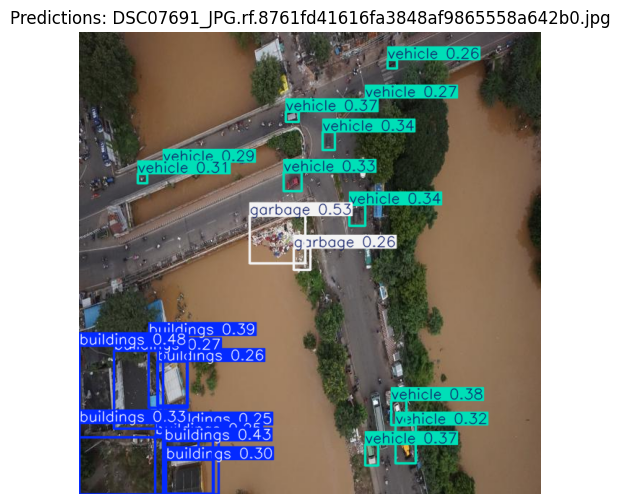

Saved prediction to /content/runs/predictions/DSC07691_JPG.rf.8761fd41616fa3848af9865558a642b0.jpg


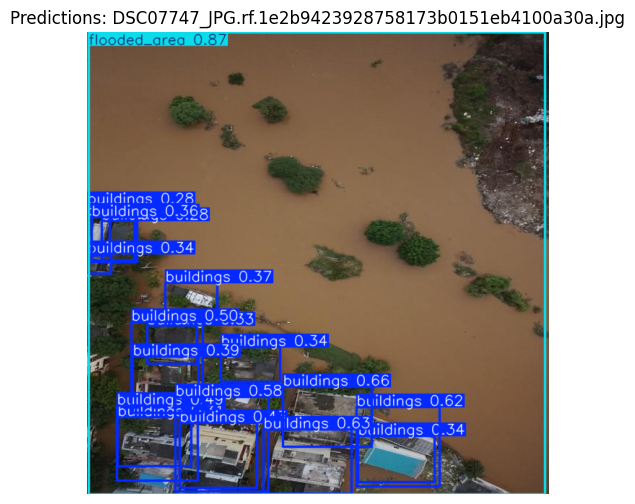

Saved prediction to /content/runs/predictions/DSC07747_JPG.rf.1e2b9423928758173b0151eb4100a30a.jpg


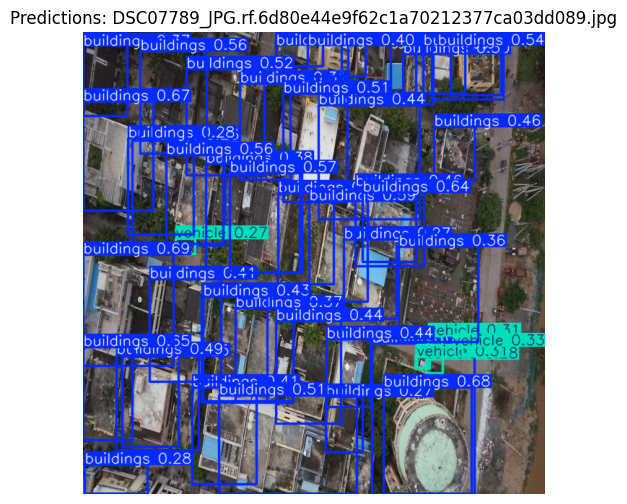

Saved prediction to /content/runs/predictions/DSC07789_JPG.rf.6d80e44e9f62c1a70212377ca03dd089.jpg


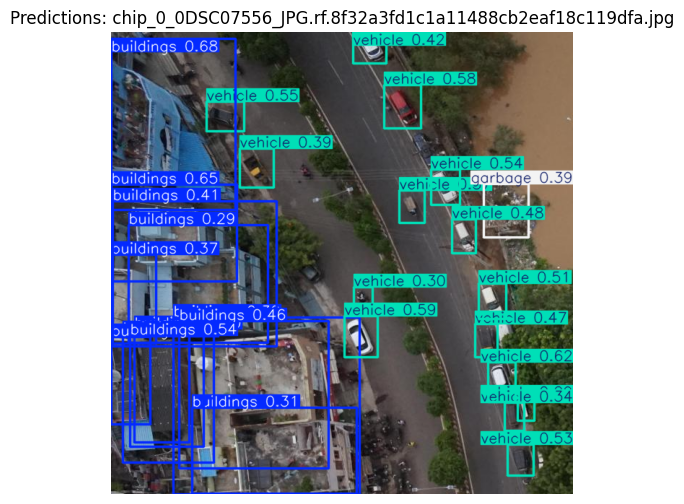

Saved prediction to /content/runs/predictions/chip_0_0DSC07556_JPG.rf.8f32a3fd1c1a11488cb2eaf18c119dfa.jpg


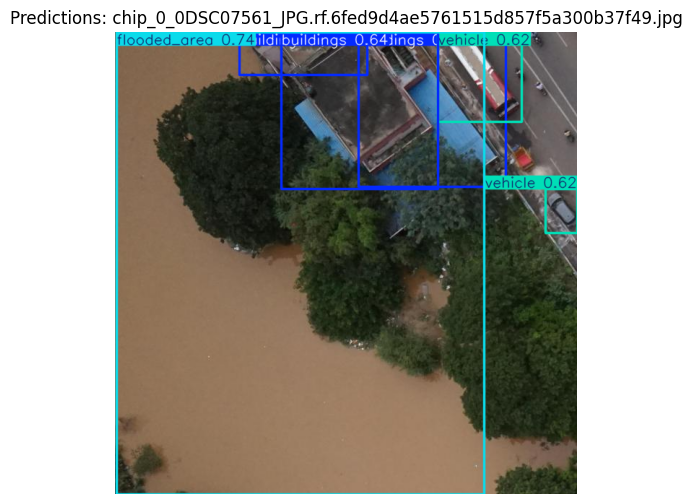

Saved prediction to /content/runs/predictions/chip_0_0DSC07561_JPG.rf.6fed9d4ae5761515d857f5a300b37f49.jpg


In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import glob
import os
import yaml


# CONFIG
MODEL_PATH = "/content/runs/detect/dhineu_train_aug3/weights/best.pt"
DATA_YAML = "/content/DHINEU_MV4-1/data_reordered.yaml"
IMAGES_DIR = "/content/DHINEU_MV4-1/valid/images"
OUT_DIR = "/content/runs/predictions"
N_IMAGES = 5
CONF_THRESH = 0.25

os.makedirs(OUT_DIR, exist_ok=True)


# Load model
model = YOLO(MODEL_PATH)

# Load reordered names from YAML
with open(DATA_YAML) as f:
    data_dict = yaml.safe_load(f)
names_list = data_dict["names"]
print("Class names:", names_list)


image_paths = sorted(glob.glob(os.path.join(IMAGES_DIR, "*.*")))
image_paths = [p for p in image_paths if p.lower().endswith((".jpg",".jpeg",".png"))][:N_IMAGES]


# Run predictions

results = model.predict(image_paths, conf=CONF_THRESH, verbose=False)


# Visualize
for img_path, res in zip(image_paths, results):
    # Plot with custom names
    plotted_img = res.plot(labels=names_list)  # pass labels here
    img_rgb = cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB)

    # Show image
    plt.figure(figsize=(8,6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Predictions: {os.path.basename(img_path)}")
    plt.show()

    # Save image
    out_path = os.path.join(OUT_DIR, os.path.basename(img_path))
    cv2.imwrite(out_path, plotted_img)
    print(f"Saved prediction to {out_path}")


In [ ]:

!pip install gradio ultralytics



In [ ]:
import cv2
import numpy as np
import random
import gradio as gr
from ultralytics import YOLO

# Load YOLOv8 model
MODEL_PATH = "/content/runs/detect/dhineu_train_aug4/weights/best.pt"
model = YOLO(MODEL_PATH)

def yolo_predict(image):
    # Run inference on the uploaded image
    results = model(image)[0]

    # Convert image to OpenCV format (BGR)
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Get class names and assign random colors
    classes = model.names
    colors = {cls_id: [random.randint(0,255) for _ in range(3)] for cls_id in classes}

    # Draw bounding boxes and labels
    for box, cls_id, conf in zip(results.boxes.xyxy, results.boxes.cls, results.boxes.conf):
        x1, y1, x2, y2 = map(int, box)
        color = colors[int(cls_id)]
        label = f"{classes[int(cls_id)]} {conf:.2f}"

        # Draw rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness=3)

        # Draw label background
        (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        cv2.rectangle(img, (x1, y1 - text_height - 5), (x1 + text_width, y1), color, -1)

        # Put text
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

    # Convert back to RGB for Gradio display
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Create Gradio interface
iface = gr.Interface(
    fn=yolo_predict,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Image(type="numpy"),
    title="YOLOv8 Object Detection",
    description="Upload an image to detect objects."
)

# Launch the Gradio app
iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://18c0e086f516bdcf18.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
